In [1]:
'''
Blair, M. R., Marcus R. Watson, R. Calen Walshe, & Fillip Maj. (2009). 
Extremely Selective Attention: Eye-Tracking Studies of the Dynamic Allocation 
of Attention to Stimulus Features in Categorization. Journal of Experimental 
Psychology: Learning, Memory, and Cognition 35(5), 1196–1206. 
https://doi.org/10.1037/a0016272.

(Experiment 2)
'''
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm import tqdm
import sys
sys.path.append('..')
import sea


In [2]:
# %% Simulation Parameters

param = {
    'MAX_RECURSION_LEVEL':  5, # 5 is standard model, 0 is myopic
    'EXPLORATION_PARAM':    0.0,
    'DECISION_PARAMETER':   1.0,
    'TOTAL_BLOCKS':         25,
    'CONSEC_BLOCKS':        3,
    'prior_matrix':         np.array([[.01, .01, .01, .01],
                              [1.0, 1.0, .00001, .00001],
                              [1.0, 1.0, .00001, .00001],
                              [1.0, 1.0, .00001, .00001]]),
    'num_dims':             4,
    'num_values':           4,
    'coupling':             .3,
    'd':                    1.0,
    'report':               False,
    'NUM_TIMES':            5,
}

# binary feature (one unit) for the first three dims and two features for
# the output
BLAIR_STIM = np.array([[0, 0, 0, 0],  # type 1
                       [0, 0, 0, 1],
                       [1, 0, 1, 0],
                       [1, 0, 1, 1],
                       [2, 1, 0, 0],
                       [2, 1, 1, 0],
                       [3, 1, 0, 1],
                       [3, 1, 1, 1]])

# which features are known when stimulus is presented?
BLAIR_KNOWN = np.array([[0, 1, 1, 1],
                        [0, 1, 1, 1],
                        [0, 1, 1, 1],
                        [0, 1, 1, 1],
                        [0, 1, 1, 1],
                        [0, 1, 1, 1],
                        [0, 1, 1, 1],
                        [0, 1, 1, 1]])

ALL_KNOWN = np.array([1, 1, 1, 1])

# what feature is unknown?
BLAIR_QUERY = np.array([[1, 0, 0, 0],
                        [1, 0, 0, 0],
                        [1, 0, 0, 0],
                        [1, 0, 0, 0],
                        [1, 0, 0, 0],
                        [1, 0, 0, 0],
                        [1, 0, 0, 0],
                        [1, 0, 0, 0]])


In [ ]:
# % functions for computing utility:

def getSituationCost(KNOWN_VEC, param):
    '''function to calculate costs for a given KNOWN_VEC (see RMC.SituationValue)

    This function assumes equal costs for each query. Can be modified for
    tasks in which some tests are more costly than others, or when sampling costs
    are not independent.'''

    return np.sum(KNOWN_VEC) * 10  # 10 is sampling cost used in paper


def dfActionVals(param):
    '''function to define utility table (e.g., table 1)

    When asym is True, this currently maximizes accuracy (i.e., correct=100
    utility units, incorrect=0 utility units).

    This function should be modified to reflect utility and cost associated
    with the final choice.'''

    m = np.diag([100] * param['num_values'])
    df = pd.DataFrame(index=['s%d' % a for a in range(param['num_values'])],
                      columns=['a%d' % a for a in range(param['num_values'])],
                      data=m)
    return df


param['getSituationCost'] = getSituationCost
param['dfActionVals'] = dfActionVals(param)


run: 100%|██████████| 5/5 [03:20<00:00, 39.64s/it]

pickling blairTransfer...
optimal:  0.9833333333333333 optimal plus extra:  0.0 other:  0.016666666666666666
dim sampled first:  [0.98333333 0.00833333 0.00833333]
2.0055555555555555 0.05


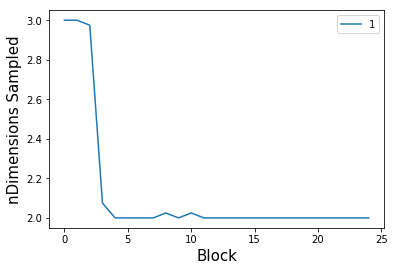

In [3]:
# %% Simulation 

model = sea.RMC(param)

blocks_correct_consec = 0
overall_correct = np.zeros([param['TOTAL_BLOCKS']])
overall_sampled = np.zeros([param['TOTAL_BLOCKS']])
item_order = np.arange(8)
totalTransDimSampled = 0
totalTransOptimal = 0
totalTransOptimalPlusExtra = 0
totalTransOther = 0
dimSampledFirst = np.array([0, 0, 0])
transAccuracy = 0

allSamples = []

run_num = 0
df_nSamplesPerDimTrain = pd.DataFrame(
    np.zeros(
        (param['NUM_TIMES'], 3)), columns=range(3), index=range(
            param['NUM_TIMES']))
df_nSamplesPerDimTrans = pd.DataFrame(
    np.zeros(
        (param['NUM_TIMES'], 3)), columns=range(3), index=range(
            param['NUM_TIMES']))
for run_num in  tqdm(range(param['NUM_TIMES']),desc='run'):
    model.Reset()
    sim_correct = np.zeros(param['TOTAL_BLOCKS'])
    numberDimSampled = np.zeros(param['TOTAL_BLOCKS'])
    allSamples.append([])

    for num_block in range(param['TOTAL_BLOCKS']):
        np.random.shuffle(item_order)
        blockCorrectProb = 1.0

        for item_num in item_order:

            tempN = model.PresentStimulus(
                BLAIR_STIM[item_num], BLAIR_KNOWN[item_num])
            for tn in tempN:
                df_nSamplesPerDimTrain.loc[run_num, tn - 1] += 1
            SAMPLED_KNOWN = np.zeros(model.NUM_DIMS)
            SAMPLED_KNOWN[tempN] = 1

            numberDimSampled[num_block] += len(tempN)
            correctProb = model.ResponseCorrectProb(
                BLAIR_STIM[item_num], SAMPLED_KNOWN)
            blockCorrectProb *= correctProb
            sim_correct[num_block] += correctProb
            model.Learn(
                BLAIR_STIM[item_num],
                SAMPLED_KNOWN,
                BLAIR_QUERY[item_num])

        if np.random.uniform(0, 1) < blockCorrectProb:
            blocks_correct_consec += 1
        else:
            blocks_correct_consec = 0
        if blocks_correct_consec == param['CONSEC_BLOCKS']:
            sim_correct[(num_block + 1):] = 8.
            numberDimSampled[(num_block +
                              1):] += float(numberDimSampled[num_block])
            break

    # exclude sims that did not reach accuracy criterion, do 72 trials without
    # feedback
    nNoLearners = 0
    if num_block >= param['TOTAL_BLOCKS']:
        nNoLearners += 1
    else:
        item_order = np.arange(8)
        for trans_block in range(9):
            for item_num in item_order:
                tempN = model.PresentStimulus(
                    BLAIR_STIM[item_num], BLAIR_KNOWN[item_num])
                for tn in tempN:
                    df_nSamplesPerDimTrans.loc[run_num, tn - 1] += 1

                allSamples[run_num].append([item_num, tempN])

                transAccuracy += model.ResponseCorrectProb(
                    BLAIR_STIM[item_num], BLAIR_KNOWN[item_num])

                totalTransDimSampled += len(tempN)
                dimSampledFirst[tempN[0] - 1] += 1

                if item_num < 4:
                    if tempN == [1, 2]:
                        totalTransOptimal += 1
                    elif tempN == [1, 2, 3]:
                        totalTransOptimalPlusExtra += 1
                    else:
                        totalTransOther += 1
                else:
                    if tempN == [1, 3]:
                        totalTransOptimal += 1
                    elif tempN == [1, 3, 2]:
                        totalTransOptimalPlusExtra += 1
                    else:
                        totalTransOther += 1
        overall_correct += sim_correct
        overall_sampled += numberDimSampled
        run_num += 1

print("pickling blairTransfer...")
pickle.dump(allSamples, open("past_samples/blairTransfer_%d_samples"%param["NUM_TIMES"], "wb"))
    
overall_sampled /= (8. * param['NUM_TIMES'])
print("optimal: ",
      float(totalTransOptimal) / (8. * param['NUM_TIMES'] * 9.),
      "optimal plus extra: ",
      float(totalTransOptimalPlusExtra) / (8. * param['NUM_TIMES'] * 9.),
      "other: ",
      float(totalTransOther) / (8. * param['NUM_TIMES'] * 9.))
print("dim sampled first: ", dimSampledFirst / (8. * param['NUM_TIMES'] * 9.))

print(totalTransDimSampled /
      (8. *
       param['NUM_TIMES'] *
       9.), overall_sampled[param['TOTAL_BLOCKS'] -
                            1] /
      (8. *
          param['NUM_TIMES']))

plt.plot(np.transpose(overall_sampled))
plt.legend(("1", "2", "3", "4", "5", "6"))
plt.ylabel('nDimensions Sampled',fontsize=15)
plt.xlabel('Block',fontsize=15)
plt.show()
plt.pause(.01)
